In [18]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
import torch.optim as optim
from cebra_utils import *

In [38]:
cebra_model_path = 'models/cebra_model_complete.pt'

data_directory = '/mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/'
neural_data_paths = [ data_directory + 'brain/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

behavior_data_paths = [  data_directory + 'camera1/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

dino_paths = [ data_directory + 'dino/' + \
                        file for file in os.listdir(data_directory + 'brain/')]

label_paths = list(filter(lambda x : x.endswith('.pickle') , iter(os.listdir('.'))))

neural_data_paths.sort()
behavior_data_paths.sort()
dino_paths.sort()
label_paths.sort()

In [68]:
num_classes = 4
solver = torch.load('models/cebra_model_complete.pt')
model_group = solver.model.eval()
prototype = nn.Sequential(nn.Linear(8, 4))
classifiers = nn.ModuleList([prototype for i in range(len(model_group))])
for param in model_group.parameters():
    param.requires_grad = False

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifiers.parameters(), lr=0.00001)

In [21]:
def single_epoch(data, names, labels, model_group, criterion, optimizer, session):
    # train the linear classifier on the labelled data
    running_loss = 0.0
    num_iter= 0
    for data, names in zip(data, names):
        # check if the data is labelled
        if names in labels:
            # do a forward pass
            output = model_group[session](torch.from_numpy(data).float())
            tiled_label = np.tile(labels[names], data.shape[0]).reshape(data.shape[0], 4)
            vid_label = torch.from_numpy(tiled_label).float()

            loss = criterion(output, vid_label)

            # do a backward pass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_iter += 1
            
    return (running_loss / num_iter)
            

def validation_run(data, names, labels, model_group, criterion, session):
    # train the linear classifier on the labelled data
    running_loss = 0.0
    num_iter= 0
    for data, names in zip(data, names):
        # check if the data is labelled
        if names in labels:
            # do a forward pass
            output = model_group[session](torch.from_numpy(data).float())
            tiled_label = np.tile(labels[names], data.shape[0]).reshape(data.shape[0], 4)
            vid_label = torch.from_numpy(tiled_label).float()

            loss = criterion(output, vid_label)

            running_loss += loss.item()
            num_iter += 1
            
    return (running_loss / num_iter)

In [69]:
loss_total = []
valid_loss_total = []
for i in range(len(label_paths)):
    print('Training session: ', i)
    print (label_paths[i] + ' ' + neural_data_paths[i])
    with open(label_paths[i], 'rb') as f:
        labels = pickle.load(f)

    # load the data
    data, names = import_data(neural_data_paths[i], lambda x: x, min = 0, max = 0.15)
    validation_data, validation_names  = import_data(neural_data_paths[i], lambda x: x, min = 0.15, max = 0.2)

    # generate embeddings
    embeddings = []
    for vid in data:
        single_embeddings = generate_CEBRA_embeddings(model_group, vid, i, offset = (2,3))
        embeddings.append(single_embeddings)

    validation_embeddings = []
    for vid in validation_data:
        single_embeddings = generate_CEBRA_embeddings(model_group, vid, i, offset = (2,3))
        validation_embeddings.append(single_embeddings)

    loss = []
    valid_loss = []
    for epoch in range(1500): 
        loss.append(single_epoch(embeddings, names, labels, classifiers, criterion, optimizer, i))
        valid_loss.append(validation_run(validation_embeddings, validation_names, labels, classifiers, criterion, i))
        print('Epoch: ', epoch, ' Loss: ', loss[-1], ' Validation Loss: ', valid_loss[-1])
    loss_total.append(loss)
    valid_loss_total.append(valid_loss)

Training session:  0
2020_11_17_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_17_MV1_run
Epoch:  0  Loss:  0.7627572660197579  Validation Loss:  0.7653615040438516
Epoch:  1  Loss:  0.759804057848962  Validation Loss:  0.762681074653353
Epoch:  2  Loss:  0.7568258493432501  Validation Loss:  0.7600436040333339
Epoch:  3  Loss:  0.7539088822089101  Validation Loss:  0.7574676070894514
Epoch:  4  Loss:  0.7510619104191025  Validation Loss:  0.7549553641251155
Epoch:  5  Loss:  0.7482846986625997  Validation Loss:  0.7525052453790392
Epoch:  6  Loss:  0.7455745138828224  Validation Loss:  0.7501143821648188
Epoch:  7  Loss:  0.742927943360749  Validation Loss:  0.7477795328412737
Epoch:  8  Loss:  0.7403413170321858  Validation Loss:  0.7454974293708801
Epoch:  9  Loss:  0.7378109032508886  Validation Loss:  0.743264753477914
Epoch:  10  Loss:  0.7353332212185972  Validation Loss:  0.7410784448896136
Epoch:  11  Loss:  0.732904931097799 

In [34]:
# sort the paths 
sorted_paths = sorted(zip(neural_data_paths, behavior_data_paths, dino_paths, label_paths), key = lambda x: x.split('/')[-1] )


AttributeError: 'tuple' object has no attribute 'split'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


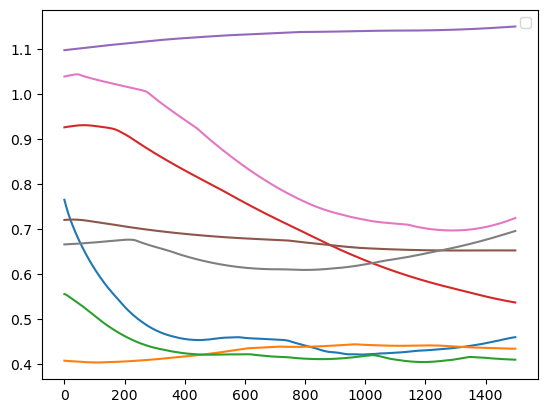

In [72]:
# plot all the losses
for i in range(len(loss_total)):
    plt.plot(valid_loss_total[i])
plt.legend()
plt.show()

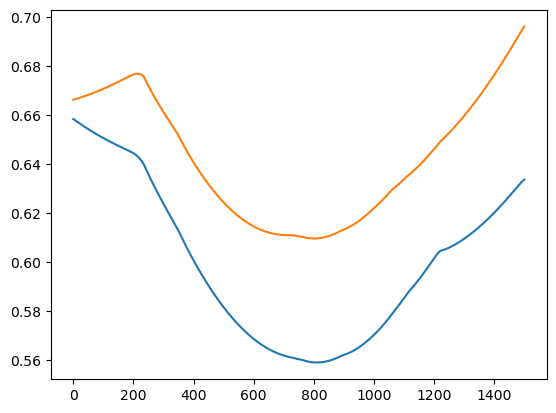

In [73]:
plt.plot(loss)
plt.plot(valid_loss)

In [54]:
classifiers[-1]

classifiers[-1][0].weight.data.normal_(0.0, 0.01)
classifiers[-1][0].bias.data.fill_(0.0)

tensor([0., 0., 0., 0.])

In [74]:
torch.save(classifiers, 'models/cebra_classifier_complete.pt')

In [77]:
model_group = torch.load('models/cebra_model_complete.pt')

In [79]:
model_group = model_group.model.eval()

In [137]:
true_labels = []
predicted_labels = []
for i in range(len(label_paths)):
    print('Training session: ', i)
    print (label_paths[i] + ' ' + neural_data_paths[i])

    with open(label_paths[i], 'rb') as f:
        labels = pickle.load(f)
    validation_data, names  = import_data(neural_data_paths[i], lambda x: x, min = 0.15, max = 0.2)

    validation_embeddings = []
    for vid in validation_data:
        single_embeddings = generate_CEBRA_embeddings(model_group, vid, i, offset = (2,3))
        validation_embeddings.append(single_embeddings)

    for data, names in zip(validation_embeddings, names):
        # check if the data is labelled
        if names in labels:
            # do a forward pass
            output = classifiers[i](torch.from_numpy(data).float())
            true_label = np.argmax(labels[names])
            vid_label = np.argmax(np.sum(output.detach().numpy(), axis= 0))
            ## take the argmax of which class it is
            
            true_labels.append(true_label)
            predicted_labels.append(vid_label)
    



        

Training session:  0
2020_11_17_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_17_MV1_run
Training session:  1
2020_11_23_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run
Training session:  2
2020_11_2_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run
Training session:  3
2020_11_9_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_9_MV1_run
Training session:  4
2020_12_10_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_10_MV1_run
Training session:  5
2020_12_4_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run
Training session:  6
2021_1_12_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run
Training session:  7


In [138]:
predicted_labels 

[1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 3,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 1,
 1,
 0,
 0,
 2,
 2,
 0,
 1,
 2,
 0,


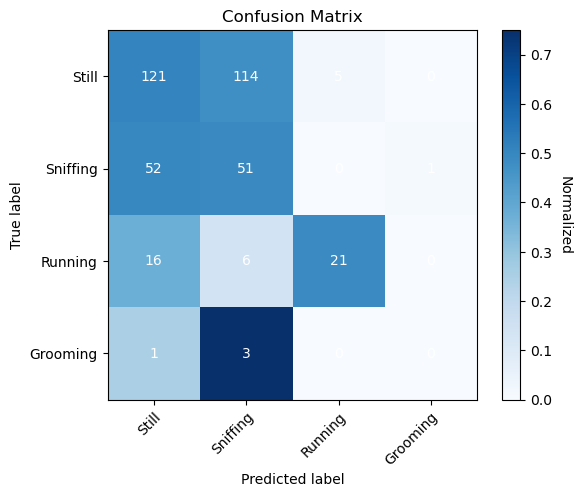

In [139]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(true_labels, predicted_labels)
# plot the confusion matrix


def plot_confusion_matrix(confusion_matrix, labels):
    # Normalize the confusion matrix
    normalized_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots()
    im = ax.imshow(normalized_matrix, cmap='Blues')

    # Set colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Normalized', rotation=-90, va="bottom")

    # Set ticks and labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{confusion_matrix[i, j]}', ha="center", va="center", color="w")

    # Set labels for the x-axis, y-axis, and title
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')

    # Show the plot
    plt.show()

plot_confusion_matrix(confusion, ['Still', 'Sniffing', 'Running', 'Grooming'])
